In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [ ]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.6/273.6 kB 31.4 MB/s eta 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_science_practice/dataset/daily_traffic.csv')
data.head()

,date_time,traffic_volume
0,9/29/2016 17:00,5551.0
1,9/29/2016 18:00,4132.0
2,9/29/2016 19:00,3435.0
3,9/29/2016 20:00,2765.0
4,9/29/2016 21:00,2443.0


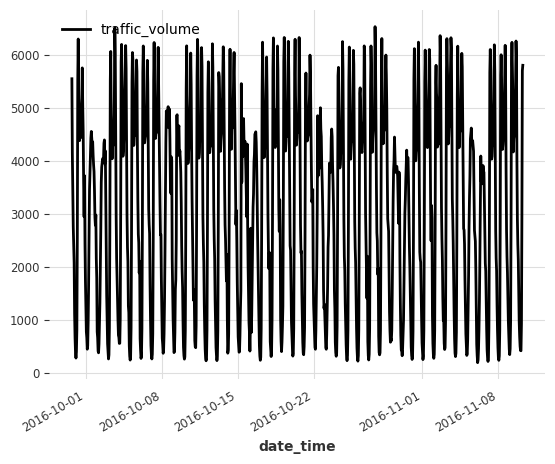

In [ ]:
from darts import TimeSeries

series_data = TimeSeries.from_dataframe(data, time_col = 'date_time')
series_data.plot()

In [ ]:
from darts.utils.statistics import check_seasonality

check_seasonality(series_data, m = 24, max_lag = 400, alpha = 0.05)

(True, 24)

In [ ]:
check_seasonality(series_data, m = 168, max_lag = 400, alpha = 0.05)

(True, 168)

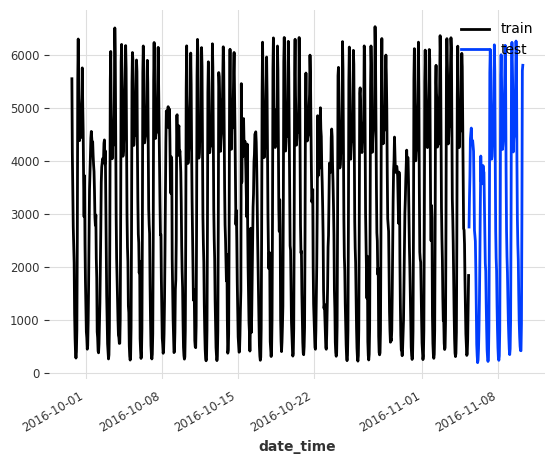

In [ ]:
train_data, test_data = series_data[:-120], series_data[-120:]
train_data.plot(label = 'train')
test_data.plot(label = 'test')

In [ ]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K = 168)
naive_seasonal.fit(train_data)

y_pred = naive_seasonal.predict(120)

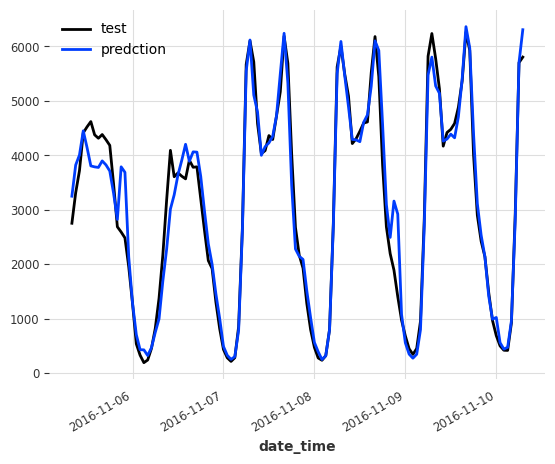

In [ ]:
test_data.plot(label = 'test')

y_pred.plot(label = 'predction')

In [ ]:
from darts.metrics import mae

mae(test_data, y_pred)

249.09166666666667

In [ ]:
import torch

seed = 1126

if torch.cuda.is_available():
  pl_trainer_kwargs = {
    "accelerator": "gpu",
    "devices": [0]
  }

In [ ]:
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train_data)

In [ ]:
from darts.models import NBEATSModel

nbeats = NBEATSModel(
    input_chunk_length = 168, output_chunk_length = 24, generic_architecture = True,
    random_state = seed, pl_trainer_kwargs = pl_trainer_kwargs
)

In [ ]:
nbeats.fit(scaled_train, epochs = 50)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.3 M 
---------------------------------------------------
7.3 M     Trainable params
2.3 K     Non-trainable params
7.3 M     Total params
29.323    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=168, output_chunk_length=24, random_state=1126, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [ ]:
y_pred = train_scaler.inverse_transform(nbeats.predict(n = 120))

mae(test_data, y_pred)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

263.6306320325563

In [ ]:
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

cov = concatenate([dt_attr(series_data.time_index, 'day', dtype = np.float32), dt_attr(series_data.time_index, 'week', dtype = np.float32)],
          axis = 'component')

In [ ]:
cov_scaler = Scaler()
scaled_cov = cov_scaler.fit_transform(cov)

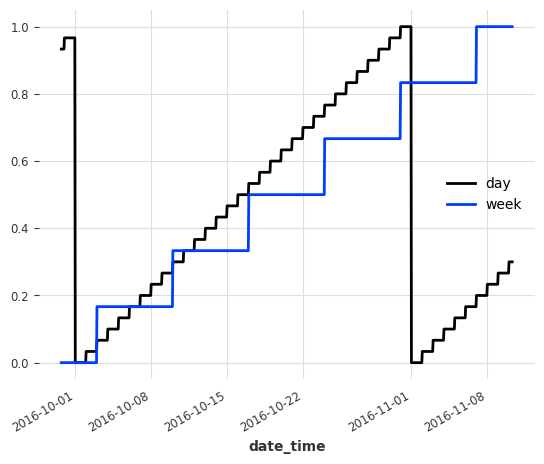

In [ ]:
scaled_cov.plot()

In [ ]:
nbeats = NBEATSModel(
    input_chunk_length = 168, output_chunk_length = 24, generic_architecture = True,
    random_state = seed, pl_trainer_kwargs = pl_trainer_kwargs
)

In [ ]:
nbeats.fit(scaled_train, epochs = 50, past_covariates = scaled_cov)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 10.0 M
---------------------------------------------------
10.0 M    Trainable params
4.3 K     Non-trainable params
10.0 M    Total params
39.922    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=168, output_chunk_length=24, random_state=1126, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [ ]:
y_pred = train_scaler.inverse_transform(nbeats.predict(n = 120))

mae(test_data, y_pred)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

256.41233227765537

In [ ]:
from darts.models import NHiTSModel

nhits = NHiTSModel(input_chunk_length = 168, output_chunk_length = 24, random_state = seed, pl_trainer_kwargs = pl_trainer_kwargs)

In [ ]:
nhits.fit(scaled_train, epochs = 100)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.0 M 
---------------------------------------------------
939 K     Trainable params
86.2 K    Non-trainable params
1.0 M     Total params
4.103     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


NHiTSModel(num_stacks=3, num_blocks=1, num_layers=2, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=168, output_chunk_length=24, random_state=1126, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [ ]:
y_pred = train_scaler.inverse_transform(nhits.predict(n = 120))

mae(test_data, y_pred)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

260.78917535403355

In [ ]:
from darts.models import TFTModel

tft = TFTModel(input_chunk_length = 168, output_chunk_length = 24, random_state = seed, pl_trainer_kwargs = pl_trainer_kwargs,
         add_relative_index = True)

In [ ]:
tft.fit(scaled_train, epochs = 100, past_covariates = scaled_cov)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | 

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


TFTModel(hidden_size=16, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=168, output_chunk_length=24, random_state=1126, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [ ]:
y_pred = train_scaler.inverse_transform(tft.predict(n = 120))

mae(test_data, y_pred)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

684.0334754954747